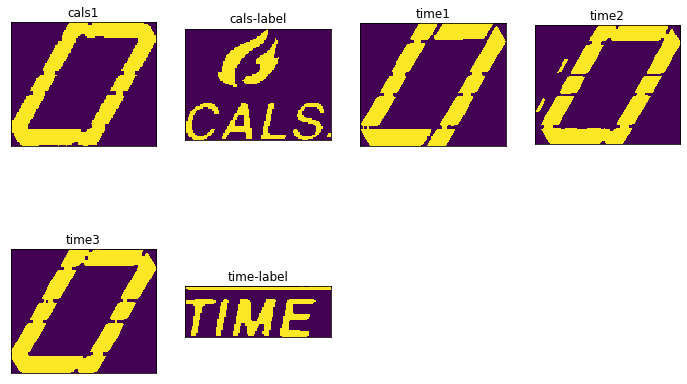

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import imutils
import numpy as np

from PIL import Image, ImageSequence, TiffTags

TIFF_PAGE_NAME_TAG_ID = [k for k,v in TiffTags.TAGS.items() if v == 'PageName'][0]

image = Image.open('template.tif')
layers = {}
for layer in ImageSequence.Iterator(image):
    layer_name = layer.tag[TIFF_PAGE_NAME_TAG_ID][0]
    layer_image = np.array(layer.convert('RGB'))
    layers[layer_name] = layer_image

background_image = layers['background']

plt.figure(figsize=(12, 16))

for i, layer_name in enumerate([k for k in layers.keys() if k != 'background']):
    mask_image = layers[layer_name]
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_RGB2GRAY)
    contours, hierarchy = cv2.findContours(mask_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 1:
        raise Exception(f'Expected exactly one contour, got {len(contours)}')
    mask_x, mask_y, mask_w, mask_h = cv2.boundingRect(contours[0])
    
    digit_image = background_image[mask_y:mask_y+mask_h, mask_x:mask_x+mask_w]
    digit_image = cv2.cvtColor(digit_image, cv2.COLOR_RGB2GRAY)
    digit_image = cv2.erode(digit_image, np.ones((2, 2), np.uint8), iterations=2)
    ret, digit_image = cv2.threshold(digit_image, 127, 255, cv2.THRESH_BINARY)
    digit_image = cv2.bitwise_and(digit_image, digit_image, 
                                  mask=mask_image[mask_y:mask_y+mask_h, mask_x:mask_x+mask_w])
    
    nonzero_coords = cv2.findNonZero(digit_image)
    nonzero_x, nonzero_y, nonzero_w, nonzero_h = cv2.boundingRect(nonzero_coords)
    digit_image = digit_image[nonzero_y:nonzero_y+nonzero_h, nonzero_x:nonzero_x+nonzero_w]

    plt.subplot(4, 4, i + 1)
    plt.title(layer_name)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(digit_image)